# Plots for $\min \|S\|_\gamma$

In [1]:
import numpy as np
import pickle, time, copy
import glob
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os, re
colors = list(mcolors.TABLEAU_COLORS)
import os.path
plt.rcParams.update({'font.size': 15})

## The minimal nuclear norm estimator

In [2]:
# A solver for the minimal nuclear norm solution
from scipy import optimize

def H0(r):
    if r <= -2:
        return 0 
    elif r >= 2:
        return 1
    else: 
        return (r*np.sqrt(4.-r**2) + 8*np.arctan((2+r)/np.sqrt(4.-r**2)))/(4*np.pi)

def H1(r):
    if r <= -2:
        return 0 
    elif r >= 2:
        return r
    else: 
        return ((8+r**2)*np.sqrt(4.-r**2) + 24*r*np.arctan((2+r)/np.sqrt(4.-r**2)))/(12*np.pi)
    
def H2(r):
    if r <= -2:
        return 0 
    elif r >= 2:
        return 1 + r**2
    else: 
        return (r*(26+r**2)*np.sqrt(4.-r**2) + 48*(1+r**2)*np.arctan((2+r)/np.sqrt(4.-r**2)))/(24*np.pi)
    
#The function to zero out 
def to_zero(x, alpha): 
    sigma, xminus, xplus = x[0], x[1], x[2]
    val1 = 2*alpha - (H2(xminus) + 1 + xplus**2 - H2(xplus))
    val2 = (xplus+xminus) - sigma*(xplus - xminus)*(H1(xminus) - (xplus - H1(xplus)))
    val3 = 1. - sigma*(H1(xminus) + (xplus - H1(xplus)))
    return [val1, val2, val3]

def solve_nn(alpha):
    sol = optimize.root(to_zero, [2, 0.1, 0.1], args = (alpha, ))
    val = sol.x
    return {'sigma':val[0], 'xminus':val[1], 'xplus':val[2], 'omega':H0(val[2])-H0(val[1])}

#The value of Tr|S|/d
def energy(sigma, xminus, xplus):
    return sigma*(H1(xminus) - (xplus - H1(xplus)))

In [3]:
#The bulk of the density, without the delta peak
def nu_nn(sigma, xminus, xplus, x):
    if x >= 0:
        return np.sqrt(max(0, 4*sigma**2 - (x-sigma*xminus)**2))/(2*np.pi*sigma**2)
    else:
        return np.sqrt(max(0, 4*sigma**2 - (x-sigma*xplus)**2))/(2*np.pi*sigma**2)

### Sketch of the evolution of the spectra and of the energy value

In [4]:
#The energy value, for 0 < alpha < 1/2
alphas = np.linspace(0, 0.5, num = 1000, endpoint=False)
energies = np.ones_like(alphas) 
for (i_a, alpha) in enumerate(alphas):
    if alpha >= 1./4:
        sol = solve_nn(alpha) 
        energies[i_a] = energy(sol['sigma'], sol['xminus'], sol['xplus'])

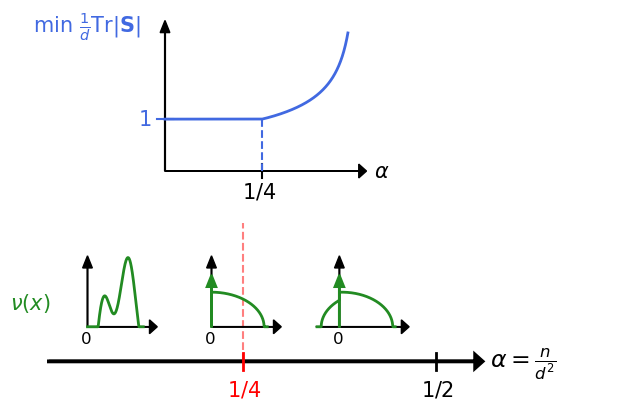

In [5]:
from matplotlib.patches import Circle, Ellipse
matplotlib.rcParams['hatch.linewidth'] = 2.25  # previous pdf hatch linewidth

width = 8
height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
fig, ax = plt.subplots(1, 1,figsize = (width,height))
ax.axis('off')
ax.set_xlim(-0.05,0.75)
ax.set_ylim(-0.1,1)

ax.arrow(0.0, 0, 0.55, 0., head_width = 0.04, head_length = 0.01, length_includes_head = False, color = 'black', linewidth = 2.5, zorder = 1)
ax.text(0.57, -0.02, r'$\alpha = \frac{n}{d^2}$',color = 'black', fontsize = 17)
ax.text(0.23, -0.1, r'$1/4$',color = 'red')
ax.plot([0.25,0.25], [-0.025,0.025] ,color = 'red',linewidth = 2)
ax.plot([0.5,0.5], [-0.025,0.025] ,color = 'black',linewidth = 2)
ax.text(0.48, -0.1, r'$1/2$',color = 'black')

ax.plot([0.25,0.25],[0., 0.4], '--', linewidth=1.5, color='red', zorder = 0, alpha = 0.5)

pos_mu = 0.3

ax.text(-0.05, 0.15, r'$\nu(x)$',color = 'ForestGreen')


x_value = 0.05
x_min, x_shift, y_base = x_value, 0.08, pos_mu-0.2
ax.arrow(x_value, y_base, x_shift, 0., head_width = 0.04, head_length = 0.01, length_includes_head = False, color = 'black', linewidth = 1, zorder = 0)
ax.arrow(x_value, y_base, 0, 0.17, head_width = 0.0125, head_length = 0.035, length_includes_head = False, color = 'black', linewidth = 1, zorder = 0)
ax.text(x_value-0.01, y_base - 0.05, r'$0$',color = 'black', fontsize = 12)
xs = np.linspace(0,1, num = 1000)
def func(x):
    value = np.sin(x*np.pi/2)**2 + np.sin(2*x*np.pi/2)**2 + np.sin(4*x*np.pi/2)**2 - 4./np.pi
    return max(0, value)


values = np.array([func(x) for x in xs])
#I rescale the xs to fit in my windows
xs_rescaled = (xs/np.amax(xs))*0.9*x_shift + x_min
values_rescaled = (values/np.amax(values))*0.2 + y_base
ax.plot(xs_rescaled, values_rescaled, color = 'ForestGreen', linewidth = 2, zorder = 1)

x_value = 0.21
alphac = 0.25
x_min, x_shift, y_base = x_value, 0.08, pos_mu-0.2
ax.arrow(x_value, y_base, x_shift, 0., head_width = 0.04, head_length = 0.01, length_includes_head = False, color = 'black', linewidth = 1, zorder = 0)
ax.arrow(x_value, y_base, 0, 0.17, head_width = 0.0125, head_length = 0.035, length_includes_head = False, color = 'black', linewidth = 1, zorder = 0)
ax.text(x_value-0.01, y_base - 0.05, r'$0$',color = 'black', fontsize = 12)
xs = np.linspace(0, 5, num = 10000)
results = solve_nn(alphac) 
values = np.array([nu_nn(results['sigma'], results['xminus'], results['xplus'], x) for x in xs])

#I rescale the xs to fit in my windows
xs_rescaled = (xs/np.amax(xs))*0.9*x_shift + x_min
values_rescaled = (values/np.amax(values))*0.1 + y_base
ax.plot(xs_rescaled, values_rescaled, color = 'ForestGreen', linewidth = 2, zorder = 1)
ax.arrow(x_value, y_base, 0, 0.15, head_width = 0.0125, head_length = 0.035, length_includes_head = True, color = 'ForestGreen', linewidth = 1.5, zorder = 1)


x_value = 0.375
alphac = 0.3
x_min, x_shift, y_base = x_value, 0.08, pos_mu-0.2
ax.arrow(x_value-0.03, y_base, x_shift+0.03, 0., head_width = 0.04, head_length = 0.01, length_includes_head = False, color = 'black', linewidth = 1, zorder = 0)
ax.arrow(x_value, y_base, 0, 0.17, head_width = 0.0125, head_length = 0.035, length_includes_head = False, color = 'black', linewidth = 1, zorder = 0)
ax.text(x_value-0.01, y_base - 0.05, r'$0$',color = 'black', fontsize = 12)
xs = np.linspace(-2, 5, num = 10000)
results = solve_nn(alphac) 
values = np.array([nu_nn(results['sigma'], results['xminus'], results['xplus'], x) for x in xs])

#I rescale the xs to fit in my windows
xs_rescaled = (xs/np.amax(xs))*0.9*x_shift + x_min
values_rescaled = (values/np.amax(values))*0.1 + y_base
ax.plot(xs_rescaled, values_rescaled, color = 'ForestGreen', linewidth = 2, zorder = 1)
ax.arrow(x_value, y_base, 0, 0.15, head_width = 0.0125, head_length = 0.035, length_includes_head = True, color = 'ForestGreen', linewidth = 1.5, zorder = 1)


#Now we do the energy value 
pos_energy = 0.55
x_min = 0.15
x_shift = 0.25
ax.arrow(x_min, pos_energy, x_shift, 0., head_width = 0.04, head_length = 0.01, length_includes_head = False, color = 'black', linewidth = 1, zorder = 0)
ax.arrow(x_min, pos_energy, 0, 0.4, head_width = 0.0125, head_length = 0.035, length_includes_head = False, color = 'black', linewidth = 1, zorder = 0)
ax.text(x_min-0.17, pos_energy+0.4, r'$\min \, \, \frac{1}{d}\mathrm{Tr}|\mathbf{S}|$',color = 'RoyalBlue')
ax.text(x_min+0.27, pos_energy-0.02, r'$\alpha$',color = 'black')
ax.plot([0.275,0.275], [pos_energy-0.02,pos_energy+0.02] ,color = 'black',linewidth = 1.5)
ax.plot([0.15-0.01,0.15+0.01], [pos_energy+0.15,pos_energy+0.15] ,color = 'RoyalBlue',linewidth = 1.5)
ax.text(x_min+0.1, pos_energy-0.08, r'$1/4$',color = 'black')
ax.text(x_min+0.115-0.15, pos_energy+0.13, r'$1$',color = 'RoyalBlue')
ax.plot([0.275, 0.275],[pos_energy, pos_energy+0.15] , '--', color = 'RoyalBlue',linewidth = 1.5)

#I rescale the alphas to fit in my windows
alphas_rescaled = (alphas/np.amax(alphas))*x_shift + x_min
energies_rescaled = (energies-np.amin(energies))*0.1 + pos_energy+0.15
ax.plot(alphas_rescaled[energies <= 3.5], energies_rescaled[energies <= 3.5], color = 'RoyalBlue', linewidth = 2, zorder = 1)
plt.savefig('../Figures/sketch_nn_spectrum.pdf', bbox_inches='tight')

### An example of a density for some $\alpha > 1/4$, and comparison with numerical simulations

In [6]:
#Loading numerical simulations 
HISTOGRAM_KWARGS = {
    'facecolor': 'darkgray',
    'edgecolor': 'black',
    'linewidth': 1}

alphacs = [0.26, 0.35]
all_evals = {}
for (i, alpha) in enumerate(alphacs):
    alpha_str = str(alpha).replace('.', '_')
    pattern = f"../Data/finite_size/evals__min_nuc__d100__a{alpha_str}__t*.csv"
    evalss = []
    for filename in glob.glob(pattern):
        evals = np.loadtxt(filename)
        evalss.append(evals)
    all_evals[f"{alpha}"] = np.hstack(evalss)
    print(len(evalss))

50
50


For alpha = 0.26, omega = 0.45138471268503877
For alpha = 0.35, omega = 0.2480832678937117


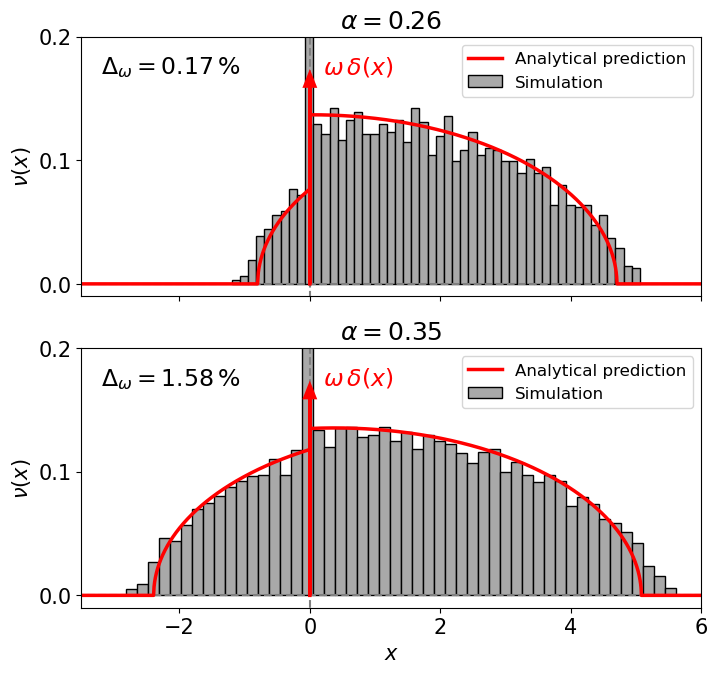

In [7]:
width = 8
height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
fig, axes = plt.subplots(2, 1,figsize = (width,1.5*height), sharex=True)
           
for (i_a, alphac) in enumerate(alphacs):
    ax = axes[i_a]
    xs = np.linspace(-5, 10, num = 10000)
    results = solve_nn(alphac) 
    values = np.array([nu_nn(results['sigma'], results['xminus'], results['xplus'], x) for x in xs])
    print(f"For alpha = {alphac}, omega = {results['omega']}")
    ax.plot(xs, values, label = r'Analytical prediction', linewidth = 2.5, color = 'red', zorder = 1)
    ax.arrow(0, 0, 0, 0.17, head_width = 0.15, head_length = 0.01, length_includes_head = True, color = 'red', linewidth = 2.5, zorder = 1)
    ax.text(0.2, 0.17, r'$\omega \, \delta(x)$',color = 'red', fontsize = 17)
    ax.hist(all_evals[f"{alphac}"], bins=50, density=True, **HISTOGRAM_KWARGS, zorder = 0, label = r'Simulation')

    
    ax.plot([-10,50],[0., 0.], '--', linewidth=1.5, color='grey', zorder = 0)
    ax.plot([0,0],[-10., 10.], '--', linewidth=1.5, color='grey', zorder = 0)
    ax.set_yticks([0,0.1,0.2])


    ax.legend(fancybox=True,loc = 'upper right', fontsize = 12)
    ax.set_ylabel(r'$\nu(x)$')
    ax.set_ylim(-0.01,0.2)
    ax.set_xlim(-3.5,6.)
    trunc = 1e-3 #Truncation for the zero eigenvalues
    omega_num = np.size(all_evals[f"{alphac}"][np.abs(all_evals[f"{alphac}"]) <= trunc])/np.size(all_evals[f"{alphac}"])
    Delta_omega = np.abs(results['omega'] - omega_num)/results['omega']
    ax.text(-3.2, 0.17, r'$\Delta_\omega = {0} \, \%$'.format(round(100.*Delta_omega,2)),color = 'black', fontsize = 17)
    
    ax.set_title(r'$\alpha = {0}$'.format(alphac))
    
axes[1].set_xlabel(r'$x$')
plt.savefig('../Figures/nu_nn_alpha_0.26_0.35.pdf', bbox_inches='tight')

## The least-squares estimator ($\gamma = 2$)

We plot a comparison with the numerics, for different values of $\alpha \in \{0.05, 0.1, 0.15\}$

In [8]:
# Analytical spectrum
def sigma_ls(alpha):
    return np.sqrt(2.*alpha / (1.-2*alpha))

#The bulk of the density
def nu_ls(sigma, x):
    return np.sqrt(max(0, 4*sigma**2 - (x-1)**2))/(2*np.pi*sigma**2)

In [9]:
#Loading numerical simulations
HISTOGRAM_KWARGS = {
    'facecolor': 'darkgray',
    'edgecolor': 'black',
    'linewidth': 1}

alphas = [0.075, 0.1, 0.15]
all_evals = {}
for (i, alpha) in enumerate(alphas):
    alpha_str = str(alpha).replace('.', '_')
    pattern = f"../Data/finite_size/evals__dist_2__d100__a{alpha_str}__t*.csv"
    evalss = []
    for filename in glob.glob(pattern):
        evals = np.loadtxt(filename)
        evalss.append(evals)
    all_evals[f"{alpha}"] = np.hstack(evalss)
    print(len(evalss))

50
50
50


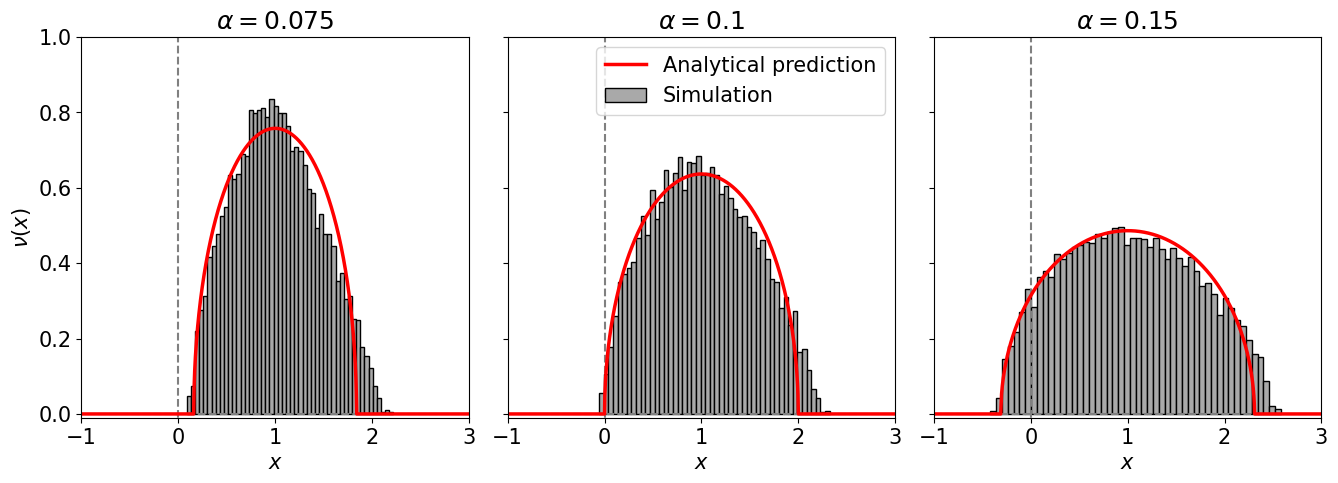

In [10]:
width = 8
height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
fig, axes = plt.subplots(1, 3,figsize = (2*width, height), sharey=True)
           
for (i_a, alpha) in enumerate(alphas):
    ax = axes[i_a]
    xs = np.linspace(-5, 10, num = 10000)
    sigma = sigma_ls(alpha)
    values = np.array([nu_ls(sigma, x) for x in xs])
    ax.plot(xs, values, label = r'Analytical prediction', linewidth = 2.5, color = 'red', zorder = 1)
    ax.hist(all_evals[f"{alpha}"], bins=50, density=True, **HISTOGRAM_KWARGS, zorder = 0, label = r'Simulation')
    
    ax.plot([-10,50],[0., 0.], '--', linewidth=1.5, color='grey', zorder = 0)
    ax.plot([0,0],[-10., 10.], '--', linewidth=1.5, color='grey', zorder = 0)
    #ax.set_yticks([0,0.1,0.2])

    ax.set_ylim(-0.01,1.)
    ax.set_xlim(-1,3.)
    ax.set_xlabel(r'$x$')

    ax.set_title(r'$\alpha = {0}$'.format(alpha))
axes[1].legend(fancybox=True,loc = 'upper right')
axes[0].set_ylabel(r'$\nu(x)$')
plt.subplots_adjust(wspace=0.1)
plt.savefig('../Figures/nu_ls.pdf', bbox_inches='tight')

## Plots of $\alpha_c(\gamma)$

In [11]:
#We load all available data

folder_path = "../Data/replica/"
gamma01s = []#

# Define a regular expression to match filenames that contain "gamma0_{}_gamma1_{}.pkl"
filename_pattern = r"Min_Sgamma_alphac_gamma0_(.*)_gamma1_(.*).pkl$"

# Loop over all files in the directory and load the data
alphacs_tmp, gammas_tmp, hs_tmp, qs_tmp, lambdams_tmp, lmins_tmp, lmaxs_tmp = [], [], [], [], [], [], []

for filename in os.listdir(folder_path):
    # Match filenames that follow the pattern
    match = re.match(filename_pattern, filename)
    if match:
        gamma0 = float(match.group(1))
        gamma1 = float(match.group(2))
        gamma01s.append([gamma0, gamma1])
        filename = f"{folder_path}Min_Sgamma_alphac_gamma0_{gamma0}_gamma1_{gamma1}.pkl"
        infile = open(filename,'rb')
        results = pickle.load(infile)
        infile.close()
        
        alphacs_tmp.append(results['alphacs']) #alphas must be sorted
        gammas_tmp.append(results['gammas'])
        hs_tmp.append(results['hs'])
        qs_tmp.append(results['qs'])
        lambdams_tmp.append(results['lambdams'])
        lmins_tmp.append(results['lmins'])
        lmaxs_tmp.append(results['lmaxs'])
        
#Now we concatenate all the available data
gammas = np.concatenate([x for x in gammas_tmp])
alphacs = np.concatenate([x for x in alphacs_tmp])
hs = np.concatenate([x for x in hs_tmp])
qs = np.concatenate([x for x in qs_tmp])
lambdams = np.concatenate([x for x in lambdams_tmp])
lmins = np.concatenate([x for x in lmins_tmp])
lmaxs = np.concatenate([x for x in lmaxs_tmp])

#Now we sort, and according to gammas
idx   = np.argsort(gammas)
gammas = np.array(gammas)[idx]
alphacs = np.array(alphacs)[idx]
hs = np.array(hs)[idx]
qs = np.array(qs)[idx]
lambdams = np.array(lambdams)[idx]
lmins = np.array(lmins)[idx]
lmaxs = np.array(lmaxs)[idx]

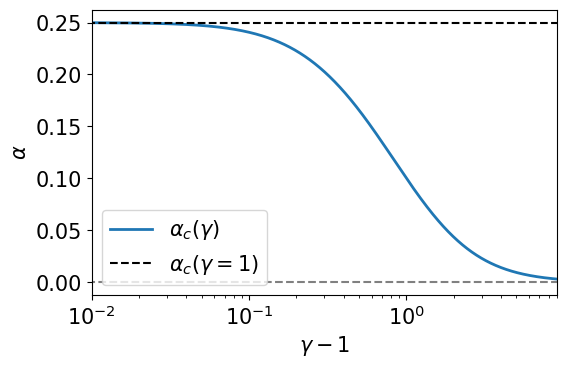

In [12]:
width = 6
height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
fig, ax = plt.subplots(1, 1,figsize = (width,height))
ax.plot(gammas-1, alphacs, linewidth = 2, color = colors[0], label = r'$\alpha_c(\gamma)$')
ax.plot([-10,50],[0.25,0.25], '--', linewidth=1.5, zorder=2, color='black', label = r'$\alpha_c(\gamma = 1)$')
ax.plot([-10,50],[0,0], '--', linewidth=1.5, zorder=2, color='grey')
ax.set_xlim(1e-2, 9) #Once I have data for smaller $\gamma$. 
ax.set_ylabel(r'$\alpha}$')
ax.set_xlabel(r'$\gamma - 1$')
ax.set_xticks([1, 9])
ax.set_xscale('log')
ax.legend(fancybox=True,loc = 'lower left')
plt.savefig('../Figures/alphac_gamma.pdf', bbox_inches='tight')

Now we plot how the spectrum at $\alpha = \alpha_c(\gamma)$ evolves as a function of $\gamma \in (1, \infty)$

In [13]:
def sc(x):
    #Standard semicircular density
    if np.abs(x) >= 2:
        return 0.
    else:
        return np.sqrt(4. - x**2) / (2.*np.pi)

def mu(x, gamma_, h, q, lambdam):
    ax = np.abs(x)
    return (2.*gamma_*(gamma_-1)*ax**(gamma_-2) / np.sqrt(q) + h*np.sqrt(q))*sc(2*np.sign(x)*gamma_*ax**(gamma_-1)/np.sqrt(q) + h*np.sqrt(q)*x + 2*lambdam/np.sqrt(q))

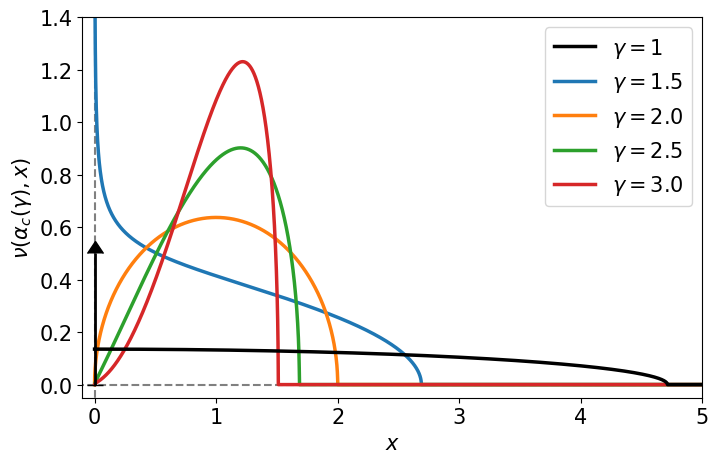

In [14]:
gammas_plot = np.array([1.5, 2, 2.5,3]) #The gammas to plot
width = 8
height = width / ((np.sqrt(5.)+1)/2.) #Golden ratio
fig, ax = plt.subplots(1, 1,figsize = (width,height))
xs = np.linspace(1e-8, 5, num = 10000)

sigma_gamma_1 = 3*np.pi/4 #At alpha = alpha_c(gamma = 1) = 1/4
values = np.array([(x>0)*(1./sigma_gamma_1)*sc(x/sigma_gamma_1) for x in xs])
ax.plot(xs, values, label = r'$\gamma = 1$', linewidth = 2.5, color = 'black', zorder = 3)
ax.errorbar(0,0.,yerr= 1./2, color='black',uplims=False,lolims=True, elinewidth=2, capsize = 6, zorder = 3)

for (_, gamma) in enumerate(gammas_plot):
    #Find the value of gamma that is the closest in the list I have
    i_g = np.argmin(np.abs(gamma - gammas))
    values = np.array([mu(x, gammas[i_g], hs[i_g], qs[i_g], lambdams[i_g]) for x in xs])
    ax.plot(xs, values, label = r'$\gamma = {0}$'.format(round(gammas[i_g],1)), linewidth = 2.5)
    
ax.plot([-10,50],[0., 0.], '--', linewidth=1.5, color='grey', zorder = 0)
ax.plot([0,0],[-1., 10.], '--', linewidth=1.5, color='grey', zorder = 0)


ax.legend(fancybox=True,loc = 'upper right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\nu(\alpha_c(\gamma), x)$')
ax.set_ylim(-0.05,1.4)
ax.set_xlim(-0.1,5)
plt.savefig('../Figures/nu_alphac_gamma.pdf', bbox_inches='tight')